In [1]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.messages import (HumanMessage, SystemMessage)
from typing import Literal
from langgraph.graph import START, END, StateGraph
from utils import tavily_search, dedupe_sources, format_web_search, format_sources_to_text
from states import SummaryState, SummaryStateOutput, SummaryStateInput
from prompts import query_generation_prompt, summarizer_prompt, reflection_prompt
from schemas import reflection_parser

In [2]:
llm = ChatOllama(model="llama3.2", temperature=0.2)
llm_json_mode = ChatOllama(model="llama3.2", temperature=0.2, json_mode=True)

In [8]:
def generate_query(state: SummaryState):
    """ 
    Generate the search query for web search based on the reseach topic.
    """
    research_topic = state['research_topic']
    query_generation_formatted = query_generation_prompt.format(research_topic=research_topic)
    chain = llm | JsonOutputParser()
    result = chain.invoke(query_generation_formatted)
    return {'search_query': result['search_query']} #This will overwrite the state

def web_search(state: SummaryState):
    current_count = state.get('research_loop_count', 0)
    search_query = state['search_query']
    search_results = tavily_search(search_query)['results']
    unique_source = dedupe_sources(search_results)
    formatted_content = format_web_search(search_results)
    sources_gathered = [{res['title']: res['url'] } for res in unique_source ]
    print(f"Research loop count: {current_count + 1}\n")
    print(f"Searching Query: {search_query}\n\n")
    return {
        'web_search_result': [formatted_content],
        "research_loop_count": current_count+1, 
        'sources_gathered': sources_gathered,
        }

def summarize_sources(state: SummaryState):
    latest_web_search = state['web_search_result']
    existing_summary = state.get('running_summary', None)
    
    if existing_summary:
        human_message = f"Topic of our research: {state['research_topic']}\n\n"
        human_message += f"Existing Summary: {existing_summary}\n\n"
        human_message += f"Extend with new search results: {latest_web_search}\n\n"
    
    else:
        human_message = f"Topic of our research: {state['research_topic']}\n\n"
        human_message += f"Generate a summary from the search results: {latest_web_search}\n\n"

    messages = [SystemMessage(content=summarizer_prompt), HumanMessage(content=human_message)]
    response = llm.invoke(messages)
    print(f"Ruuning summary: {response.content}\n{'#'*50}\n")
    return {'running_summary': response.content}

def review_summary(state: SummaryState):
    """ Review existing summary and generate a follow-up search query. """
    existing_summary = state.get('running_summary', None)
    human_message = f"Analyze,identify the knowledge gaps and generate a follow-up search query based on the existing knowledge so far: {existing_summary}"
    messages = [SystemMessage(content=reflection_prompt.format(reflection_schema=reflection_parser.get_format_instructions())), HumanMessage(content=human_message)]
    chain = llm | JsonOutputParser()
    response = chain.invoke(messages)
    return {'search_query': response['follow_up_query']}

def route_research(state: SummaryState) -> Literal["review_summary", "finalize_summary"]:
    n = 3
    if state['research_loop_count'] < n:
        return "review_summary"
    else:
        return "finalize_summary"

def finalize_summary(state: SummaryState):
    """ Attach the sources gathered to the final summary. """
    existing_summary = state.get('running_summary', None)
    all_sources = format_sources_to_text(state['sources_gathered'])
    final_summary = f"{existing_summary} +\n\nSources:\n{all_sources}"
    return {'running_summary': final_summary}

In [9]:
builder = StateGraph(SummaryState, input=SummaryStateInput, output=SummaryStateOutput)
builder.add_node('generate_query', generate_query)
builder.add_node('web_search', web_search)
builder.add_node('summarize_sources', summarize_sources)
builder.add_node('review_summary', review_summary)
builder.add_node('finalize_summary', finalize_summary)

builder.add_edge(START, 'generate_query')
builder.add_edge('generate_query', 'web_search')
builder.add_edge('web_search', 'summarize_sources')
builder.add_conditional_edges('summarize_sources', route_research)
builder.add_edge('review_summary', 'web_search')
builder.add_edge('finalize_summary', END)

In [10]:
graph = builder.compile()

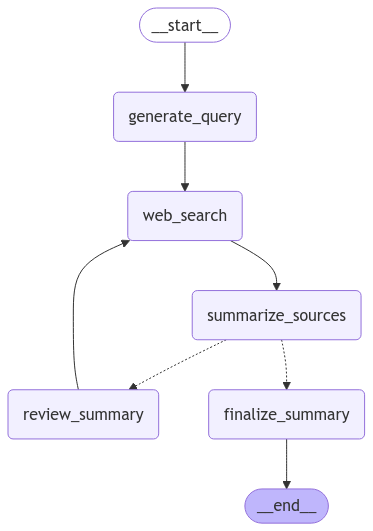

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
research_input = SummaryStateInput(research_topic='climate change')
summary = graph.invoke(research_input)

Research loop count: 1

Searching Query: climate change impact on global sea levels


Ruuning summary: **The Alarming Reality of Sea Level Rise: A Global Threat**

As the world grapples with the challenges of climate change, one of the most pressing concerns is sea level rise. The melting of ice sheets in Greenland and Antarctica is contributing significantly to this phenomenon, posing a global threat to coastal communities and ecosystems.

According to the World Economic Forum, sea level rise is one of the top two threats to the world in the coming decade, with collapsing ice sheets identified as a key contributing factor. The Global Risks Report 2024 highlights the critical change to Earth systems as a major concern, with sea level rise from melting ice sheets being a significant contributor.

**The Science Behind Sea Level Rise**

Climate change is the primary driver of global sea level rise, with rising temperatures causing ice sheets in Greenland and Antarctica to melt at an accel

In [13]:
print(summary['running_summary'])

Based on the provided sources, here is a comprehensive overview of the topic:

**Climate-Resilient Infrastructure**

Climate-resilient infrastructure refers to buildings, roads, bridges, and other physical structures designed to withstand or mitigate the impacts of climate change. This includes measures such as sea walls, levees, and green roofs.

**Challenges in Developing Countries**

Developing countries face significant challenges in building climate-resilient infrastructure due to limited financial resources, inadequate institutional capacity, and lack of access to technology and expertise.

**Importance of Climate-Resilient Infrastructure**

Climate-resilient infrastructure is crucial for protecting human life, property, and economic development. According to the OECD, an annual investment of USD 6.9 trillion in sustainable infrastructure is needed globally by 2030 to meet climate and development objectives.

**Benefits of Climate-Resilient Infrastructure**

Research from the MIT